# KNN Modeling 

## Pull & Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## Pipeline for TFIDF on KNN

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
tfidf_knn_pipe = Pipeline([
 ('tfidf', TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words = 'english')),
 ('knn', KNeighborsClassifier())
])

In [13]:
tfidf_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words='english',
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                ('knn', KNeighborsClassifier())])

In [22]:
tfidf_knn_params = {
    'tfidf__max_features':[25_000, 10_000, 1_000, 100],
    'knn__n_neighbors': [3, 5, 11, 19],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
gs_tfidf_knn = GridSearchCV(tfidf_knn_pipe,
                            param_grid=tfidf_knn_params, 
                            cv = 3, 
                            verbose = 1)

In [25]:
gs_tfidf_knn.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 119.5min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english',
                                                        token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 11, 19],
                         'knn__weights': ['uniform', 'distance'],
                         'tfidf__max_features': [25000, 10000, 1000, 100]},
             verbose=1)

In [26]:
gs_tfidf_knn.best_score_

0.9238841269582009

In [27]:
gs_tfidf_knn.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, stop_words='english',
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3,
                                      weights='distance'))])

In [28]:
gs_tfidf_knn.best_params_

{'knn__metric': 'manhattan',
 'knn__n_neighbors': 3,
 'knn__weights': 'distance',
 'tfidf__max_features': 10000}

## Natural Language Processing (NLP)

The goal here will actually to be to not only use grid searches but to also test both TF-IDF (Term Frequency - Inverse Document Frequency) and Count Vectorizers to see which performs better with each model

### TF-IDF on Validation Set

In [11]:
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
sw = stopwords.words('english')

In [13]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [15]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [32]:
tfidf = TfidfVectorizer()
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.20, random_state=3,
                                         stratify = y_train)

In [33]:
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [34]:
X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

### TF-IDF on Entire Training Set

In [19]:
token_test_docs = [doc_preparer(doc, sw) for doc in X_test]

In [35]:
tfidf_final = TfidfVectorizer()

In [36]:
X_final_t_vec = tfidf_final.fit_transform(token_docs)
X_final_t_vec = pd.DataFrame.sparse.from_spmatrix(X_final_t_vec)
X_final_t_vec.columns = sorted(tfidf_final.vocabulary_)
X_final_t_vec.set_index(y_train.index, inplace=True)

In [37]:
X_final_test_vec = tfidf_final.transform(token_test_docs)
X_final_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_final_test_vec)
X_final_test_vec.columns = sorted(tfidf_final.vocabulary_)
X_final_test_vec.set_index(y_test.index, inplace=True)

### Count Vectorizer on Validation Set

In [38]:
cv = CountVectorizer()
X_c_vec = cv.fit_transform(X_t)
X_c_vec = pd.DataFrame.sparse.from_spmatrix(X_c_vec)
X_c_vec.columns = sorted(cv.vocabulary_)
X_c_vec.set_index(y_t.index, inplace=True)

In [39]:
X_c_val_vec = cv.transform(X_val)
X_c_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_c_val_vec)
X_c_val_vec.columns = sorted(cv.vocabulary_)
X_c_val_vec.set_index(y_val.index, inplace=True)

### Count Vectorizer on Entire Training Set

In [40]:
cv_best_final = CountVectorizer()

In [41]:
X_final_c_vec = cv_best_final.fit_transform(token_docs)
X_final_c_vec = pd.DataFrame.sparse.from_spmatrix(X_final_c_vec)
X_final_c_vec.columns = sorted(cv_best_final.vocabulary_)
X_final_c_vec.set_index(y_train.index, inplace=True)

In [42]:
X_final_test_c_vec = cv_best_final.transform(token_test_docs)
X_final_test_c_vec  = pd.DataFrame.sparse.from_spmatrix(X_final_test_c_vec)
X_final_test_c_vec.columns = sorted(cv_best_final.vocabulary_)
X_final_test_c_vec.set_index(y_test.index, inplace=True)

## Modeling TF-IDF on Simple KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [44]:
KNN_tfidf = KNeighborsClassifier()
KNN_tfidf.fit(X_t_vec, y_t)
KNN_tfidf.score(X_t_vec, y_t)

0.9219965623303782

In [45]:
cross_val_score(KNN_tfidf, X_t_vec, y_t, cv = 5)

array([0.91870194, 0.91880584, 0.91971051, 0.91857967, 0.91959742])

In [46]:
KNN_tfidf.score(X_val_vec, y_val)

0.9207598371777477

In [47]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

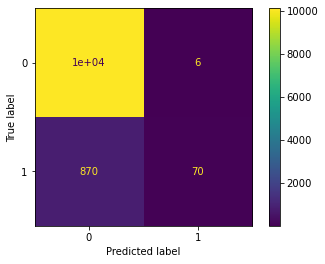

In [48]:
plot_confusion_matrix(KNN_tfidf, X_val_vec, y_val);

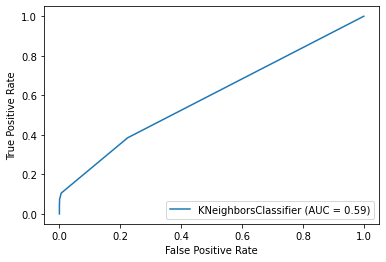

In [49]:
plot_roc_curve(KNN_tfidf, X_val_vec, y_val);

In [50]:
y_hat = KNN_tfidf.predict(X_val_vec)
print(classification_report(y_pred = y_hat, y_true = y_val))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10115
           1       0.92      0.07      0.14       940

    accuracy                           0.92     11055
   macro avg       0.92      0.54      0.55     11055
weighted avg       0.92      0.92      0.89     11055



## Modeling Count Vectorizer on Simple KNN

In [51]:
KNN_cv = KNeighborsClassifier()
KNN_cv.fit(X_c_vec, y_t)
KNN_cv.score(X_c_vec, y_t)

0.9285100416138954

In [52]:
cross_val_score(KNN_cv, X_c_vec, y_t, cv = 5)

array([0.91983265, 0.92118059, 0.92118059, 0.92118059, 0.92265068])

In [53]:
KNN_cv.score(X_c_val_vec, y_val)

0.9221166892808684

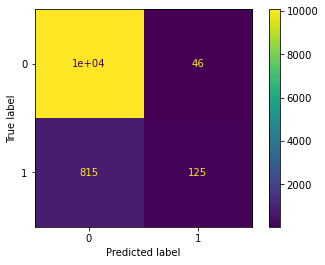

In [54]:
plot_confusion_matrix(KNN_cv, X_c_val_vec, y_val);

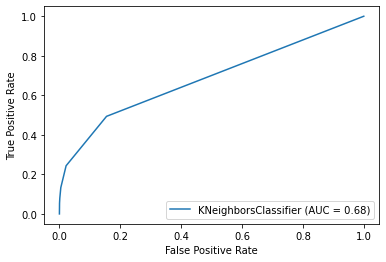

In [55]:
plot_roc_curve(KNN_cv, X_c_val_vec, y_val);

In [57]:
y_hat_2 = KNN_cv.predict(X_c_val_vec)
print(classification_report(y_pred = y_hat_2, y_true = y_val))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     10115
           1       0.73      0.13      0.23       940

    accuracy                           0.92     11055
   macro avg       0.83      0.56      0.59     11055
weighted avg       0.91      0.92      0.90     11055



## Grid Search for TF-IDF on KNN on Entire Training Set

In [58]:
from sklearn.model_selection import GridSearchCV
grid_params = {'n_neighbors': [3, 5, 11, 19],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan'],
              }

In [59]:
gs = GridSearchCV(KNeighborsClassifier(),
                 grid_params,
                 verbose = 1,
                 cv = 3,
                 n_jobs = 3)

In [60]:
gs.fit(X_final_t_vec, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed: 156.0min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=3,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [61]:
gs.best_score_

0.9234498969697861

In [62]:
gs.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [63]:
gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

## Grid Search for Count Vectorizer on KNN

In [64]:
gs_2 = GridSearchCV(KNeighborsClassifier(),
                 grid_params,
                 verbose = 1,
                 cv = 3,
                    n_jobs = 3)

In [65]:
gs_2.fit(X_final_c_vec, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed: 147.7min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=3,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [66]:
gs_2.best_score_ 

0.9248249445236881

In [67]:
gs_2.best_estimator_ 

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [68]:
gs_2.best_params_ 

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

## Final Best Possible KNN Models of TFIDF and Count Vectorizer Using The Entire Training Set

### Best Possible KNN Model For Entire Training Set Using TF-IDF

In [58]:
KNN_final_best_tfidf = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, weights = 'distance')
KNN_final_best_tfidf.fit(X_final_t_vec, y_train)
KNN_final_best_tfidf.score(X_final_t_vec, y_train)

0.9997286099401133

In [59]:
cross_val_score(KNN_final_best_tfidf, X_final_t_vec, y_train, cv = 5)

array([0.92501131, 0.92500452, 0.92364755, 0.9245522 , 0.92500452])

In [60]:
KNN_final_best_tfidf.score(X_final_test_vec, y_test)

0.9253148067737733

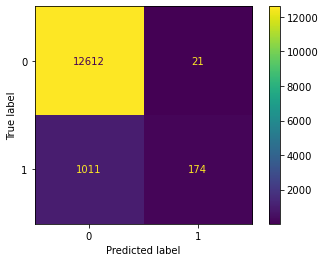

In [61]:
plot_confusion_matrix(KNN_final_best_tfidf, X_final_test_vec, y_test);

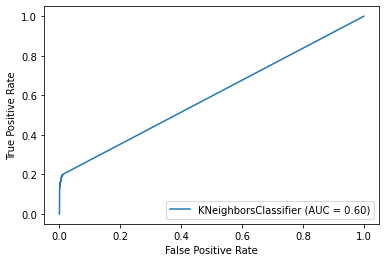

In [62]:
plot_roc_curve(KNN_final_best_tfidf, X_final_test_vec, y_test);

In [63]:
y_hat_final_tfidf = KNN_final_best_tfidf.predict(X_final_test_vec)
print(classification_report(y_pred = y_hat_final_tfidf, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     12633
           1       0.89      0.15      0.25      1185

    accuracy                           0.93     13818
   macro avg       0.91      0.57      0.61     13818
weighted avg       0.92      0.93      0.90     13818



### Best Possible KNN Model For Entire Training Set Using Count Vectorizer

In [68]:
KNN_final_best_cv = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, weights = 'distance')
KNN_final_best_cv.fit(X_final_c_vec, y_train)
KNN_final_best_cv.score(X_final_c_vec, y_train)

0.9997286099401133

In [69]:
cross_val_score(KNN_final_best_cv, X_final_c_vec, y_train, cv = 5)

array([0.92618725, 0.92536638, 0.92545685, 0.92554731, 0.9263615 ])

In [70]:
KNN_final_best_cv.score(X_final_test_c_vec, y_test)

0.9260385005065856

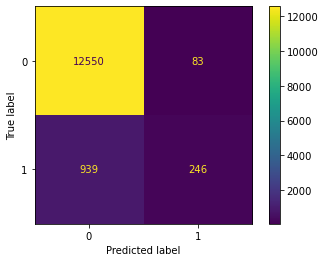

In [71]:
plot_confusion_matrix(KNN_final_best_cv, X_final_test_c_vec, y_test);

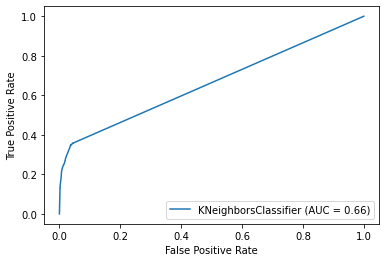

In [72]:
plot_roc_curve(KNN_final_best_cv, X_final_test_c_vec, y_test);

In [73]:
y_hat_final_cv = KNN_final_best_cv.predict(X_final_test_c_vec)
print(classification_report(y_pred = y_hat_final_cv, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12633
           1       0.75      0.21      0.32      1185

    accuracy                           0.93     13818
   macro avg       0.84      0.60      0.64     13818
weighted avg       0.91      0.93      0.91     13818

